# Comparacion de rendimiento de algoritmos de clasificacion para nuestro dataset de Burn Rate.

### *Logistic Regression vs Random Forest vs Decision Tree vs SVM*

#### Importacion de librerias

In [328]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [329]:
# importar dataset
df = pd.read_csv('train.csv')

In [330]:
# Nombres columnas
df.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [331]:
# info de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [332]:
# descripcion estadistica
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Employee ID,22750,22750,fffe31003000350034003900,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date of Joining,22750,366,2008-01-06,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,22750,2,Female,11908,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company Type,22750,2,Service,14833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WFH Setup Available,22750,2,Yes,12290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Designation,22750.0,NaN,NaN,NaN,2.178725,1.135145,0.0,1.0,2.0,3.0,5.0
Resource Allocation,21369.0,NaN,NaN,NaN,4.481398,2.047211,1.0,3.0,4.0,6.0,10.0
Mental Fatigue Score,20633.0,NaN,NaN,NaN,5.728188,1.920839,0.0,4.6,5.9,7.1,10.0
Burn Rate,21626.0,NaN,NaN,NaN,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0


In [333]:
# Borrado de nulos
df.dropna(inplace=True)

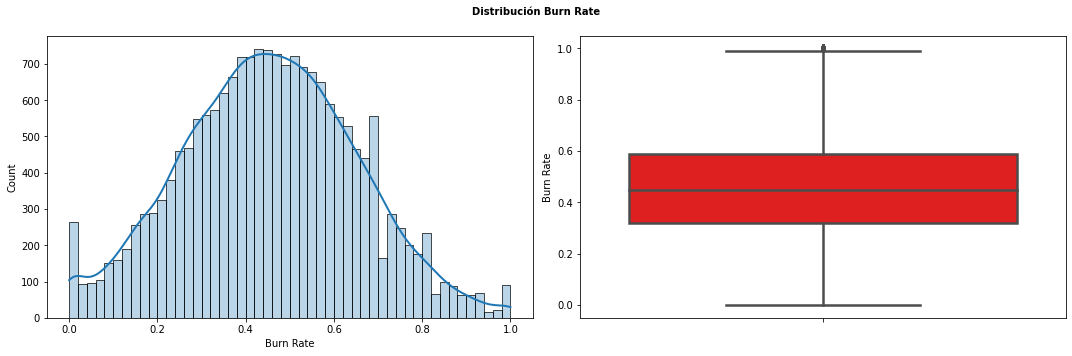

In [334]:
# Analisis de nueva clasificacion para Burn Rate de esta manera se podra aplicar segun mi criterio a una clasificacion binaria de estres.

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

sns.histplot(
    data    = df,
    x       = 'Burn Rate',
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    alpha   = 0.3,
    ax      = axes[0]
)
sns.boxplot(
    x=None, 
    y='Burn Rate',
    hue=None, 
    data=df,
    order=None, 
    hue_order=None,
    orient=None, 
    color='Red', 
    palette=None, 
    saturation=.75,
    width=.8, 
    dodge=True, 
    fliersize=5, 
    linewidth=2.5,
    whis=1.5, 
    ax=axes[1],
)

fig.show()

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución Burn Rate', fontsize = 10, fontweight = "bold");

In [335]:
# Se genera una nueva variable la cual si el valor del burn rate supera su mediana tendra un valor de 1, definido como estresado,
# si es menor a la mediana tendra un valor de 0, significante de no estresado, esto para fines practicos del algoritmo.

valorDivision= df['Burn Rate'].quantile(0.75)
# valorDivision= df['Burn Rate'].median()
# valorDivision= df['Burn Rate'].mean()

def rangeBurnRate(x):
    if x < valorDivision:
        return 0
    else:
        return 1

df['burn_rate_new'] = df['Burn Rate'].apply(lambda x :rangeBurnRate(x) )

df.burn_rate_new.value_counts(normalize=True)

0    0.74653
1    0.25347
Name: burn_rate_new, dtype: float64

In [336]:
# Funcion para transformacion de X_train y X_test para hacer reproducible el modelo.
def transformacion(x):
    columnas ={
        'WFH Setup Available':'home_office',
        'Resource Allocation': 'res_allo',
        'Gender':'sex',
        'Designation':'desig',
        'Company Type':'comp_type',
        'Date of Joining':'date_join',
        'Employee ID':'id_employee',
        'Burn Rate':'burn_rate',
        'Mental Fatigue Score':'men_fat_score'
    }

    x.rename(columns=columnas,inplace=True)

    # Realizo transformacion de Designation y Resource Allocation para poder generar su aplicacion de One Hot Encoding, 
    # al ser variables numericas.
    x['desig']= x['desig'].astype('object')
    x['res_allo'] = x['res_allo'].astype('object')

    # Realizamos la aplicacion del one hote encoding para las columnas transformadas.
    x_encoder= pd.get_dummies(x[['sex','comp_type','home_office','desig','res_allo']])

    return x,x_encoder
    

# Aplicacion Modelo de Regresion Logistica

#### *Es un método para problemas de clasificación, en los que se obtienen un valor binario entre 0 y 1.*

#### *La Regresión Logística describe y estima la relación entre una variable binaria dependiente y las variables independientes*

#### *Separacion de caracteristicas y variable objetivo*

In [337]:
# separo las features en X e y
caracteristicas = df.drop(['burn_rate_new','Burn Rate','Employee ID','Date of Joining'],axis=1)
objetivo = df[['burn_rate_new']]

#### *Genero el split*

In [338]:
# Separo el dataset en Train y Test, al no estar desbalanceado.
X_train,X_test,y_train,y_test = train_test_split(
    caracteristicas,
    objetivo,
    test_size=0.3,
    random_state=42,
    stratify=objetivo
)

#### *Transformar X_train*

In [339]:
X_train,X_train_encoder = transformacion(X_train)

#### *Creacion de modelo*

In [340]:
lg = LogisticRegression(
        penalty="l2",
        dual=False,
        tol=1e-4,
        C=1.0,
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=34,
        solver="lbfgs",
        max_iter=100,
        multi_class="auto",
        verbose=0,
        warm_start=False,
        n_jobs=1,
        l1_ratio=None,
)

# Entreno el modelo
lg.fit(X_train_encoder,y_train)

LogisticRegression(n_jobs=1, random_state=34)

#### *Transformar X_test*

In [341]:
X_test,X_test_encoder = transformacion(X_test)

### *Prediccion*

In [342]:
# Hago la prediccion
y_predict = lg.predict(X_test_encoder)

### *Vista de comparacion de prediccion vs testeo*

In [343]:
X_test['pred'] = y_predict
X_test['target'] = y_test
X_test.sample(10)

,sex,comp_type,home_office,desig,res_allo,men_fat_score,pred,target
5528,Male,Service,Yes,2.0,2.0,2.6,0,0
8917,Male,Service,Yes,2.0,2.0,4.4,0,0
10818,Male,Product,Yes,2.0,3.0,3.8,0,0
8948,Female,Service,No,3.0,6.0,7.1,0,1
14783,Male,Service,No,1.0,4.0,6.3,0,0
13795,Female,Product,No,1.0,3.0,4.7,0,0
4090,Female,Product,Yes,1.0,4.0,5.3,0,0
19605,Female,Service,Yes,1.0,2.0,5.6,0,0
22406,Female,Service,No,0.0,1.0,2.5,0,0
6988,Male,Service,No,4.0,8.0,7.0,1,0


### *Metricas R2*

In [344]:
# Accuracy para Train y Test
lg_train_r2 = lg.score(X_train_encoder,y_train)
lg_test_r2 = lg.score(X_test_encoder,y_test)

# Calculo para el accuracy de Train
print(f'% de aciertos para el entrenamiento: {lg_train_r2}')

# Calculo para el accuracy de Test
print(f'% de aciertos para la prediccion: {lg_test_r2}')

% de aciertos para el entrenamiento: 0.8632137093675555
% de aciertos para la prediccion: 0.8601398601398601


### *Matriz de confusion*

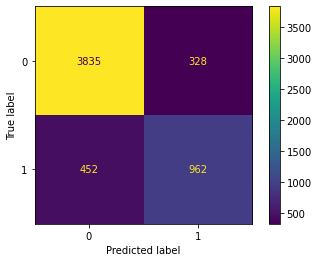

In [345]:
lg_confusion_matriz = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(lg, X_test_encoder, y_test)

### *Metricas de clasificacion*

In [346]:
lg_clasification_report = classification_report(y_test,y_predict)
print(lg_clasification_report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4163
           1       0.75      0.68      0.71      1414

    accuracy                           0.86      5577
   macro avg       0.82      0.80      0.81      5577
weighted avg       0.86      0.86      0.86      5577



### *Vista de features mas importantes*

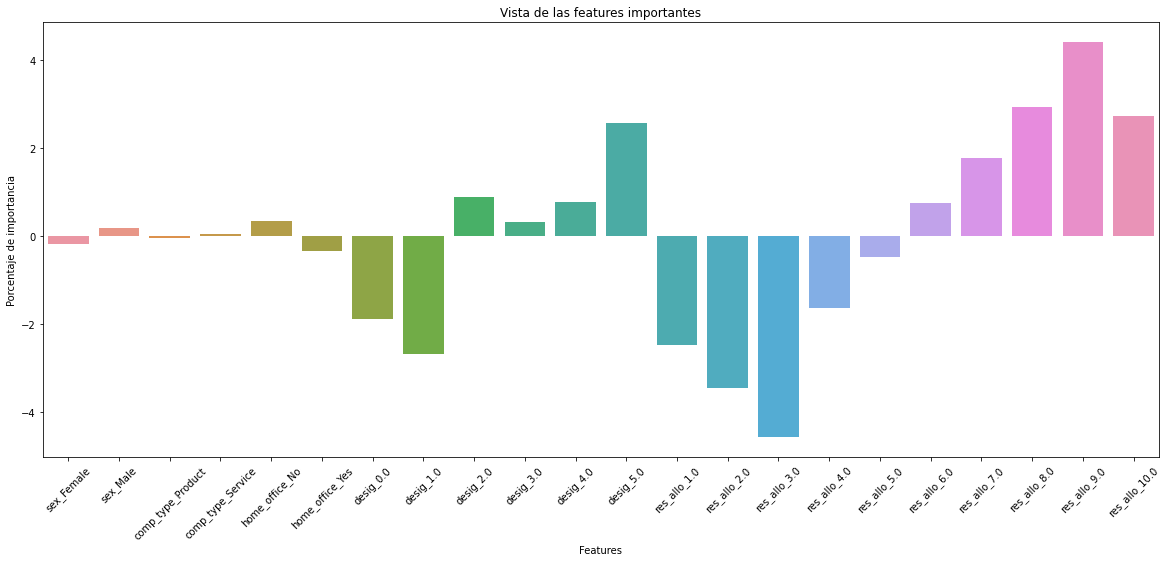

In [347]:
# Grafico las features mas importantes
df_features_importance = pd.DataFrame({
    'Feature':list(lg.feature_names_in_),
    'Importance':list(lg.coef_[0])
})

# print(df_features_importance)

plt.figure(figsize=(20,8))
sns.barplot(
    df_features_importance.Feature,
    df_features_importance.Importance,
    orient='v'
)
plt.title('Vista de las features importantes')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Porcentaje de importancia')
plt.show()

# Aplicacion Modelo de Random Forest

### *Random Forest es un tipo de Ensamble en Machine Learning en donde combinaremos diversos árboles de decisión.*

### *También llamados métodos combinados, intentan ayudar a mejorar el rendimiento de los modelos de Machine Learning. Este es un proceso mediante el cual se construyen estratégicamente varios modelos de ML para resolver un problema particular.*



### *Separacion de caracteristicas y target*

In [348]:
# separo las features en X e y
X = df.drop(['burn_rate_new','Burn Rate','Employee ID','Date of Joining'],axis=1)
y = df[['burn_rate_new']]

### *Genero el split*

In [349]:
# Separo el dataset en Train y Test, al no estar desbalanceado.
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### *Transformar X_train*

In [350]:
X_train,X_train_encoder = transformacion(X_train)

### *Creacion de modelo*

In [351]:
# Todos los argumentos vienen por default, no se modifico ninguno.
rf = RandomForestClassifier(
        n_estimators=100,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
)

### *Entrenamiento*

In [352]:
# Entreno el modelo
rf.fit(X_train_encoder,y_train)

RandomForestClassifier()

### *Transformar X_test*

In [353]:
X_test,X_test_encoder = transformacion(X_test)

### *Prediccion*

In [354]:
# Hago la prediccion
y_predict = rf.predict(X_test_encoder)

### *Vista de comparacion de prediccion vs testeo*

In [355]:
X_test['pred'] = y_predict
X_test['target'] = y_test
X_test.sample(10)

,sex,comp_type,home_office,desig,res_allo,men_fat_score,pred,target
10559,Female,Product,Yes,4.0,8.0,7.8,1,1
6816,Male,Product,Yes,3.0,5.0,4.2,0,0
16058,Male,Service,Yes,3.0,6.0,5.4,0,0
20892,Female,Product,Yes,1.0,2.0,4.4,0,0
10655,Male,Service,Yes,3.0,4.0,5.0,0,0
4725,Female,Product,Yes,2.0,6.0,7.4,1,1
11718,Female,Product,No,3.0,6.0,5.9,0,0
4989,Male,Service,No,2.0,2.0,2.8,0,0
18524,Male,Product,No,4.0,7.0,7.4,1,1
10033,Female,Service,Yes,1.0,1.0,2.2,0,0


### *Metricas*

In [356]:
# Accuracy para Train y Test
rf_train_r2 = rf.score(X_train_encoder,y_train)
rf_test_r2 = rf.score(X_test_encoder,y_test)

# Calculo para el accuracy de Train
print(f'% de aciertos para el entrenamiento: {rf_train_r2}')

# Calculo para el accuracy de Test
print(f'% de aciertos para la prediccion: {rf_test_r2}')

% de aciertos para el entrenamiento: 0.8645969415200184
% de aciertos para la prediccion: 0.8612157073695536


### *Matriz de confusion*

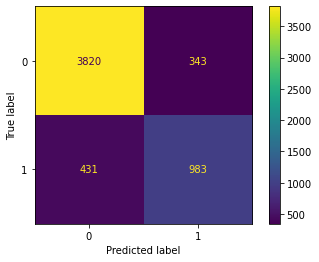

In [357]:
rf_confusion_matriz = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(rf, X_test_encoder, y_test)

### *Metricas de clasificacion*

In [358]:
rf_clasification_report = classification_report(y_test,y_predict)
print(rf_clasification_report)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4163
           1       0.74      0.70      0.72      1414

    accuracy                           0.86      5577
   macro avg       0.82      0.81      0.81      5577
weighted avg       0.86      0.86      0.86      5577



### *Vista de features mas importantes*

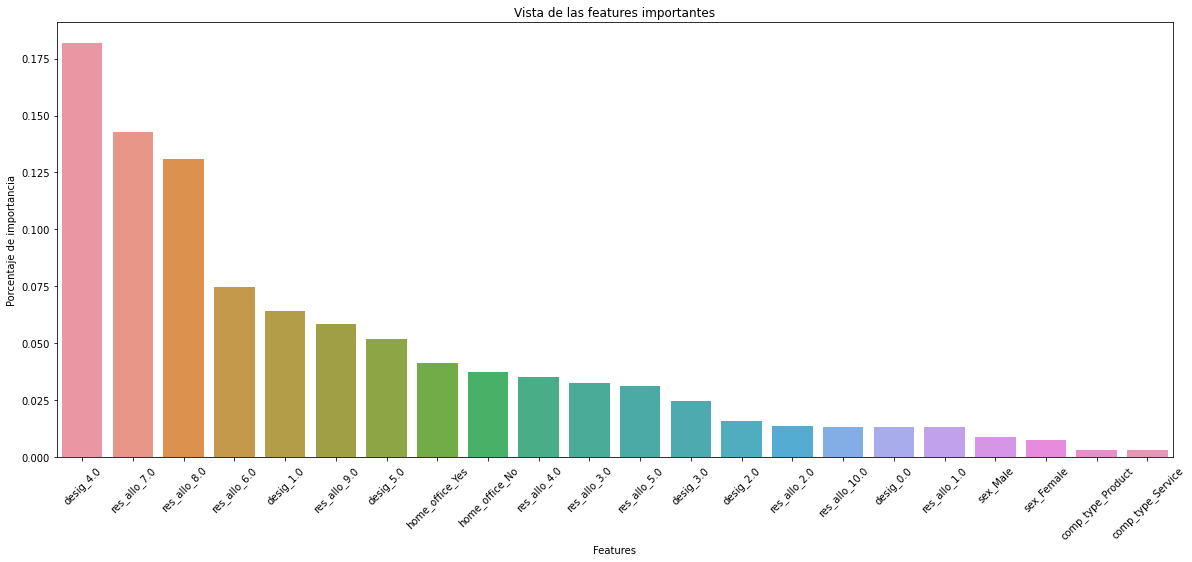

In [359]:
# Grafico las features mas importantes
df_features_importance = pd.DataFrame({
    'Feature':list(rf.feature_names_in_),
    'Importance':list(rf.feature_importances_)
}).sort_values(by='Importance',ascending=False)

# print(df_features_importance)

plt.figure(figsize=(20,8))
sns.barplot(
    df_features_importance.Feature,
    df_features_importance.Importance,
    orient='v'
)
plt.title('Vista de las features importantes')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Porcentaje de importancia')
plt.show()

# Algoritmo de clasificacion - Decision Tree Regressor

### *Decision Tree es un algoritmo que se basa en arboles , los cuales tiene un sentido de pensamiento de if - else*

### *La verdad como todo algoritmo se necesita que todos los datos sea numericos y ademas es un algortimo supervisado,  es decir que depende de una variable target, sea numerica o categorica*

#### *Separacion de caracteristicas y target*

In [360]:
# separo las features en X e y
X = df.drop(['burn_rate_new','Burn Rate','Employee ID','Date of Joining'],axis=1)
y = df[['burn_rate_new']]

#### *Genero el split*

In [361]:
# Separo el dataset en Train y Test
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=None
)

#### *Transformar X_train*

In [362]:
# Transformo X_train
X_train,X_train_encoder = transformacion(X_train)

#### *Creacion de modelo*

In [363]:
# Creo y entreno el modelo
dtc = DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=None,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        class_weight=None,
        ccp_alpha=0.0,
)

#### *Entrenamiento*

In [364]:
# Entreno
entrenamiento = dtc.fit(X_train_encoder,y_train)

#### *Transformar X_test*

In [365]:
# Transformo X_test
X_test,X_test_encoder = transformacion(X_test)

#### *Prediccion*

In [366]:
# Hago la prediccion
prediccion = dtc.predict(X_test_encoder)

#### *Vista de comparacion de prediccion vs testeo*

In [367]:
# Accuracy para Train y Test
dtc_train_r2 = dtc.score(X_train_encoder,y_train)
dtc_test_r2 = dtc.score(X_test_encoder,y_test)

# Calculo para el accuracy de Train
print(f'% de aciertos para el entrenamiento: {dtc_train_r2}')

# Calculo para el accuracy de Test
print(f'% de aciertos para la prediccion: {dtc_test_r2}')


% de aciertos para el entrenamiento: 0.8641358641358642
% de aciertos para la prediccion: 0.8628294782140936


#### Matriz de confusion

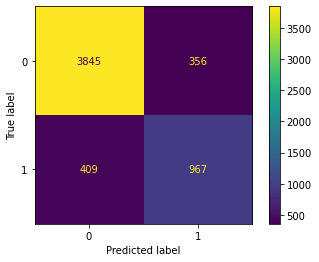

In [368]:
dtc_confusion_matriz = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(dtc, X_test_encoder, y_test)

#### Metricas de clasificacion

In [369]:
dtc_clasification_report = classification_report(y_test,y_predict)
print(dtc_clasification_report)

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      4201
           1       0.24      0.23      0.24      1376

    accuracy                           0.63      5577
   macro avg       0.50      0.50      0.50      5577
weighted avg       0.62      0.63      0.63      5577



#### Features mas importantes

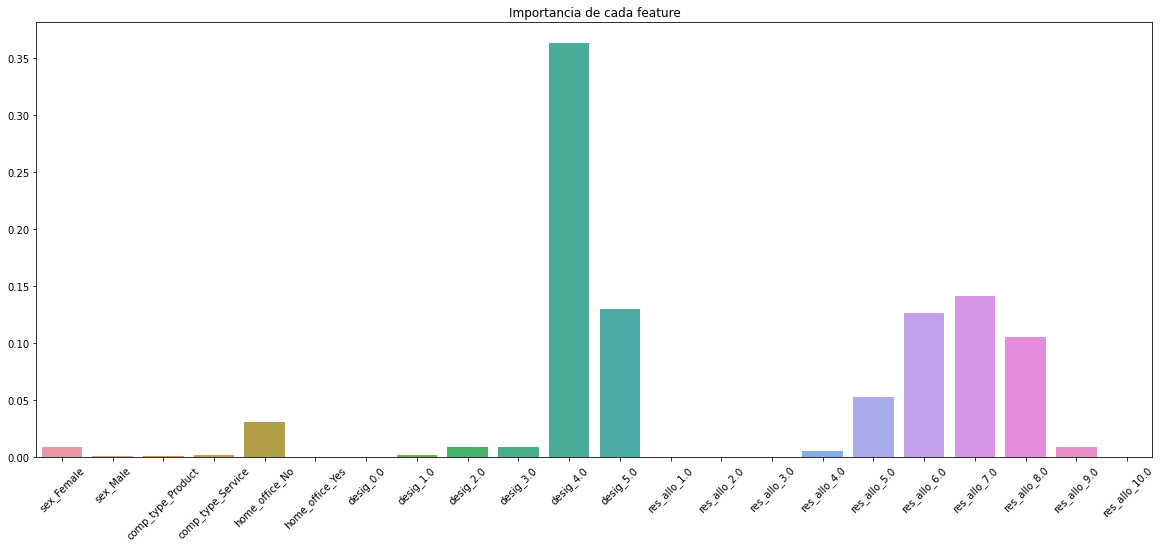

In [370]:
# Grafico las features mas importantes
importances = dtc.feature_importances_
columnas = dtc.feature_names_in_
plt.figure(figsize=(20,8))
sns.barplot(columnas,importances)
plt.title('Importancia de cada feature')
plt.xticks(rotation=45)
plt.show()

# Matriz de confusion y Accuracy para cada Algoritmo

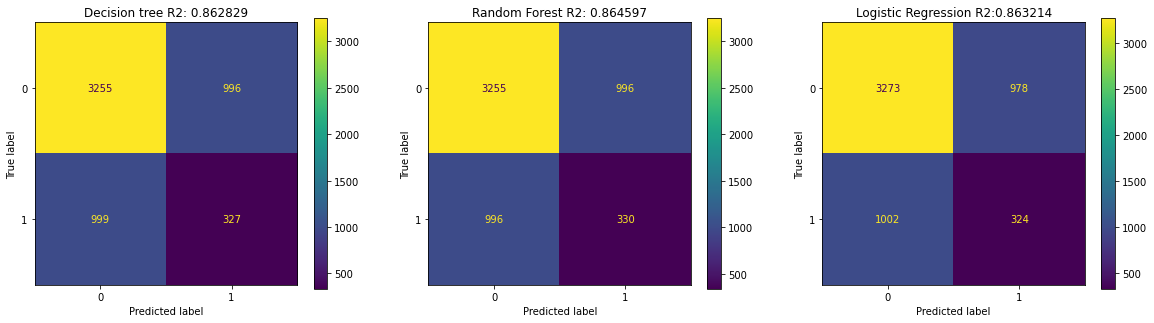

In [371]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))

plot_confusion_matrix(dtc,X_test_encoder,y_predict,ax=axes[0]);
axes[0].set_title(f'Decision tree R2: {round(dtc_test_r2,6)}')

plot_confusion_matrix(rf,X_test_encoder,y_predict,ax=axes[1]);
axes[1].set_title(f'Random Forest R2: {round(rf_train_r2,6)}')

plot_confusion_matrix(lg,X_test_encoder,y_predict,ax=axes[2]);
axes[2].set_title(f'Logistic Regression R2:{round(lg_train_r2,6)}')

fig.show()

# Algoritmo de clasificacion - SVM Support Vector Machine

*Es un algoritmo que encuentra el hiperplano que maximiza el margen de separacion entre clases*

#### *Transformo el x_train*

In [372]:
X_train, X_train_encoder = transformacion(X_train)

#### *Creacion del modelo*

In [373]:
svc = SVC(
        C=1.0,
        kernel="rbf",
        degree=3,
        gamma="scale",
        coef0=0.0,
        shrinking=True,
        probability=False,
        tol=1e-3,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=-1,
        decision_function_shape="ovr",
        break_ties=False,
        random_state=None,
)

#### *Entreno*

In [374]:
svc_train = svc.fit(X_train_encoder,y_train)

#### *Transformo el X_test*

In [375]:
X_test,X_test_encoder = transformacion(X_test)

#### *Prediccion*

In [376]:
svc_predict = svc.predict(X_test_encoder)

#### *Vista de comparacion de prediccion vs testeo*

In [377]:
# Accuracy para Train y Test
svc_train_r2 = svc.score(X_train_encoder,y_train)
svc_test_r2 = svc.score(X_test_encoder,y_test)

# Calculo para el accuracy de Train
print(f'% de aciertos para el entrenamiento: {svc_train_r2}')

# Calculo para el accuracy de Test
print(f'% de aciertos para la prediccion: {svc_test_r2}')

% de aciertos para el entrenamiento: 0.8640590179051717
% de aciertos para la prediccion: 0.8631880939573248


#### Matriz de confusion

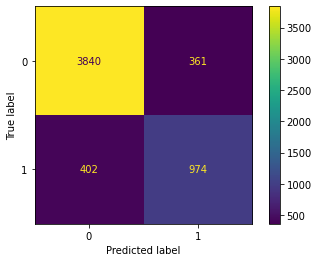

In [378]:
svc_confusion_matriz = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(svc, X_test_encoder, y_test)

#### Metricas de clasificacion

In [379]:
svc_clasification_report = classification_report(y_test,y_predict)
print(svc_clasification_report)

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      4201
           1       0.24      0.23      0.24      1376

    accuracy                           0.63      5577
   macro avg       0.50      0.50      0.50      5577
weighted avg       0.62      0.63      0.63      5577



# Matriz de confusion y Accuracy para cada Algoritmo

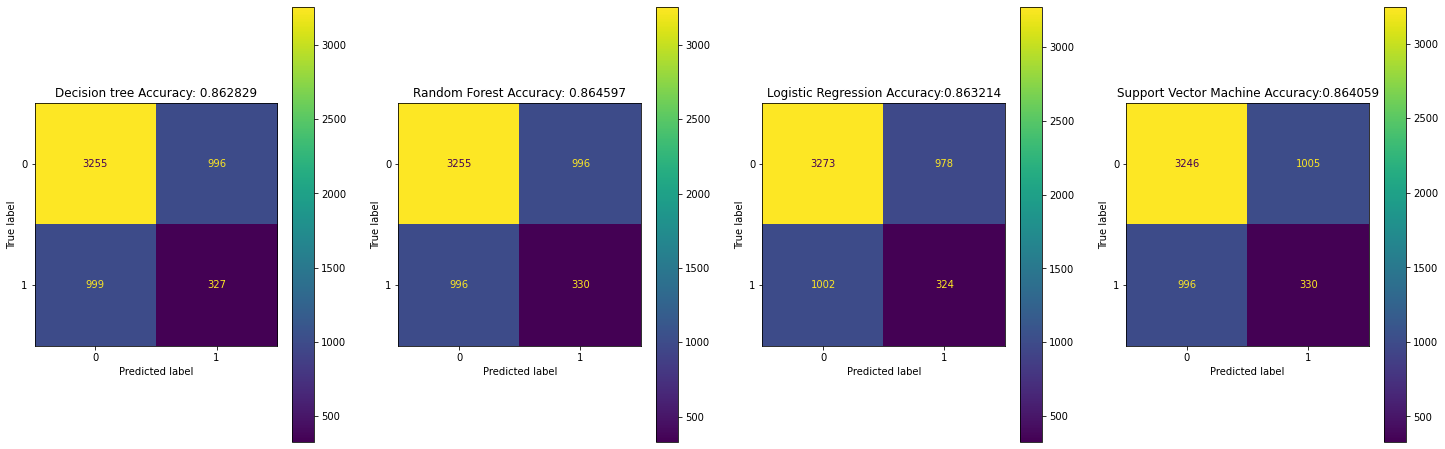

In [380]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(25,8))

plot_confusion_matrix(dtc,X_test_encoder,y_predict,ax=axes[0]);
axes[0].set_title(f'Decision tree Accuracy: {round(dtc_test_r2,6)}')

plot_confusion_matrix(rf,X_test_encoder,y_predict,ax=axes[1]);
axes[1].set_title(f'Random Forest Accuracy: {round(rf_train_r2,6)}')

plot_confusion_matrix(lg,X_test_encoder,y_predict,ax=axes[2]);
axes[2].set_title(f'Logistic Regression Accuracy:{round(lg_train_r2,6)}')

plot_confusion_matrix(svc,X_test_encoder,y_predict,ax=axes[3]);
axes[3].set_title(f'Support Vector Machine Accuracy:{round(svc_train_r2,6)}')

fig.show()

In [381]:
d = {
    'DecisionTreeClassifier':[dtc_test_r2],
    'LogisticRegression':[lg_test_r2],
    'RandomForestClassifier':[rf_test_r2],
    'SupportVector Machine':[svc_test_r2]
}

data = pd.DataFrame(data=d)

data.T.rename(columns={0:'Accuracy'}).sort_values(by='Cantidad',ascending=False)

,Cantidad
SupportVector Machine,0.863188
DecisionTreeClassifier,0.862829
RandomForestClassifier,0.861216
LogisticRegression,0.860140
